# Roteiro 2
Nesse notebook, vamos implementar uma transissão de rádio AM. Os objetivos são 

* Projetar um sistema de modulação
* Especificar um filtro real
* Identificar as consequências do teorema da convolução e da modulação
* Separar sinais que ocupam porções diferentes do espectro

## Relatório
As questões do roteiro devem ser respondidas em um arquivo google docs e submetidas no google classroom. Anexe uma cópia dos códigos utilizados e um breve vídeo explicando o que foi feito.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Nesse notebook, vamos criar uma transmissão AM usando o alto falante de seu computador. Para isso, vamos usar fato de que o alto-falante responde geralmente a frequências até acima de 10kHz, mas um sinal de voz pode ser bem representado usando frequências abaixo de 4 kHz. Ou seja, a faixa do alto-falante é muito maior do que a necessária para representar o sinal de voz. Nosso "rádio AM" vai transmitir um segundo sinal de voz nessas frequências não usadas.

Inicialmente, vamos ver uma resposta em frequência de um sistema onde eu reproduzo um som no meu celular, e capturo no microfone do meu laptop. O resultado está ilustrado na figura abaixo.

<img src="https://drive.google.com/uc?id=1L8SrtqXnQvnx5Mn9uQUf9NAnOfuw1Cbn" alt="Alt text that describes the graphic" title="Title text" style = "width: 20cm"/>

Observe como de fato o sistema responde bem a frequências até cerca de 12 kHz.

Como o sinal de voz não usa as frequências acima de 4 kHz, podemos explorar essas frequências para transmitir um segundo sinal ao mesmo tempo em que reproduzimos um sinal de voz normal. Claro, esse segundo sinal não será um sinal de voz "normal", e terá que passar por algum processamento tanto na transmissão quanto na recepção para que ele passe a ocupar a faixa de frequência esperada (acima de 4 kHz) e para que possamos, na recepção, escutá-lo corretamente. O objtivo desse experimento é fazer esse processamento, de forma a transmitir simultaneamente dois sinais de voz usando o alto falante, e depois recuperar ambos os sinais.

Usaremos duas ferramentas para atingir esse objetivo: filtragem e modulação. Como lembrete, o teorema da modulação a tempo contínuo diz que se um sinal $x_c(t)$ tem transformada de Fourier $X_c(\omega)$, então a transformada de $x_c(t)\cos(\omega_c t)$ é dada por 
$$x_c(t)\cos(\omega_c t) \Leftrightarrow \frac{1}{2}\left(X_c(\omega - \omega_c) + X_c(\omega + \omega_c) \right).$$
O sinal $\cos(\omega_c t)$ é chamado de portadora, e $\omega_c$ é chamado de frequência da portadora.

Graficamente, o resultado no domínio da frequência é representado como na figura abaixo.

<img src="https://drive.google.com/uc?id=1TJX_6XS4eqVpxPcf225BAM-ENI-xoVJ8" alt="Alt text that describes the graphic" title="Title text" style = "width: 15cm"/>

O resultado a tempo discreto é semelhante: se um sinal $x_d[n]$ tem transformada de Fourier $X_d(\Omega)$, então a transformada de $x_d[n]\cos(\Omega_c n)$ é dada por
$$x_d[n]\cos(\Omega_c n) \Leftrightarrow \frac{1}{2}\left(X_d(\Omega - \Omega_c) + X_d(\Omega + \Omega_c) \right).$$ 

No domínio do tempo, o sinal modulado fica como mostrado no gráfico abaixo.

<img src="https://drive.google.com/uc?id=1Tk5LmYJgwby_ijas5HQIitB8iApY6fUP" alt="Alt text that describes the graphic" title="Title text" style = "width: 15cm"/>

Nessa figura, a curva em azul representa o sinal modulado $x_m(t) = x_c(t) \cos(2\pi f_c t)$, para uma frequência de portadora $f_c = 8$ kHz. A curva em vermelho mostra o sinal $x_c(t)$ original, e a curva em verde representa $-x_c(t)$. Observe que o sinal modulado é igual a $x_c(t)$ nos instantes em que a portadora, ou seja, o cosseno, vale $1$. Da mesma forma, $x_m(t) = -x_c(t)$ quando o cosseno vale $-1$. Finalmente, observe que o sinal modulado oscila entre esses dois extremos a medida que a portadora oscila entre $1$ e $-1$.

O processo de transmissão é o seguinte. Em primeiro lugar, ambos os sinais são individualmente filtrados, para eliminar qualquer ruído ou componentes em frequência pouco relevantes acima de 4 kHz, buscando garantir que de fato eles não possuem frequências acima de 4 kHz. Para o segundo sinal, usaremos o teorema da modulação para produzir um sinal modulado que ocupe frequências acima de 4 kHz, e que, assim, não interfira com o primeiro sinal. Os dois sinais são somados e o resultado é reproduzido no alto falante.

Na recepção, inicialmente os dois sinais são separados. Como não há sobreposição entre eles no domínio da frequência, essa separação pode ser feita usando filtros. Para o primeiro sinal, após a separação não há mais nada a ser feito, ele pode ser reproduzido diretamente. O segundo sinal ainda tem que ser demodulado antes que ele possa ser escutado de forma inteligível. A demodulação envolve uma segunda operação de modulação, e uma filtragem passa-baixas.

O princípio aqui é semelhante ao usado em rádios AM. Nesse caso, as antenas de um rádio AM conseguem receber e transmitir frequências em uma faixa com largura maior do que 4 kHz. A modulação é usada para levar o sinal de cada estação para uma faixa de frequências diferente. Na recepção, o sinal da estação de interesse é isolado por uma filtragem e demodulado, permitindo que o usuário ouça a estação desejada. Para ressaltar essa analogia, vamos chamar os dois sinais do experimento de estação 1 e estação 2.

Vamos inicialmente carregar os dois sinais que queremos reproduzir, carregar algumas bibliotecas do Python.

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import IPython.display as ipd


Em seguida, vamos carregar e ouvir dois sinais de áudio, garantindo que ambos possuam o mesmo número de amostras. O comando abaixo também permite ouvir o sinal.

In [ ]:
from scipy.io import wavfile

fs, station2 = wavfile.read('altas.wav')
fs, station1 = wavfile.read('baixas.wav')

#Vamos garantir que os dois sinais possuem o mesmo número de amostras

station2 = station2[:100000]
station1 = station1[:100000]

ipd.Audio(station1[:100000],rate=fs)

A primeira pergunta é teórica. Suponha que a maior frequência presente nos dois sinais seja 3 kHz e o alto falante reproduza frequências até 12 kHz.

* Em que faixa deve estar a frequência da portadora para que não haja sobreposição entre os sinais no domínio da frequência, e para que o sinal modulado ainda possa ser transmitido?

* Trace o espectro em frequência dos sinais das suas estações. 

Pode usar o código usado no primeiro experimento. **Aqui, como em todo o relatório, mostre apenas as frequências positivas do espectro**. Observe que a maior frequência presente nos sinais é de fato bem menor que 4 kHz.

Como vemos, ambos os sinais ocupam frequências predominantes abaixo de 2 kHz. Para eliminar ainda mais as frequências acima disso, diminuindo ainda mais as interferências entre os sinais, vamos passar ambos por um filtro passa baixas com frequência de corte em 3 kHz. Poderíamos, aqui, fazer como no experimento anterior e filtrar diretamente no domínio da frequência: capturamos todo sinal, calculamos sua transformada, zeramos alguns componentes. Isso é possível até em um sinal em tempo real, que vai sendo filtrado à medida que é recebido: basta dividir o sinal em blocos e fazemos o procedimento anterior para cada blocol É necessário tomar alguns cuidados com a transição entre os blocos, empregando métodos como overlap-and-add ou overlap-and-save. 

Entretanto, para sistemas operando em tempo real, em geral se usa um filtro no domínio do tempo, como o filtro de Butterworth. Nesse caso, usa-se o domínio em frequência para especificar as características desejadas do filtro, e então projeta-se o filtro, determinando quais polos e zeros produzem a resposta em frequência desejada. Mas a filtragem em si é feita no domínio do tempo. Para sinais analógicos, frequentemente essa é a única opção. 

Assim, vamos usar aqui o filtro Butterworth, e não a estratégia de filtragem do experimento 1. Para ilustrar como a filtragem no domínio do tempo é feita em Python, a célula abaixo já traz a implementação dessas operações.

O uso do filtro no formato sos tem relação com a estabilidade das operações. Isso é um tema mais avançado, para este experimento basta saber que sem isso não seria possível implementar o filtro. Um filtro de ordem 8 é suficiente para garantir a qualidade do resultado. O comando freqz permite facilmente traçar a resposta em frequência do filtro resultante.

Caso você queira ver como implementar um filtro na prática, esse site tem recursos muito interessantes: https://tools.analog.com/en/filterwizard/

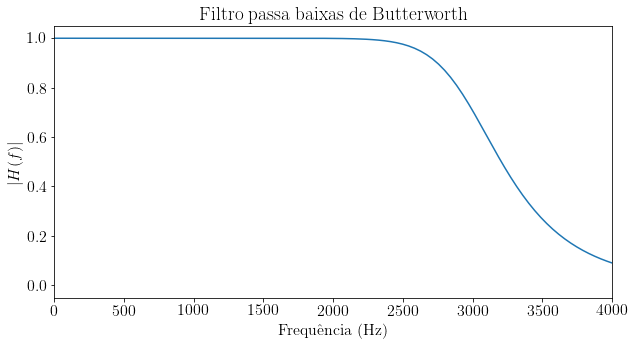

In [ ]:
#Projeta o filtro
sos = signal.butter(8, 3000, 'low', fs = fs, output = 'sos')

#Plota a resposta em frequência do filtro
w,h = signal.sosfreqz(sos,fs = fs)
plt.plot(w,np.abs(h));
plt.xlim((0,4000))
plt.xlabel('Frequência (Hz)')
plt.ylabel('$|H(f)|$')
plt.title('Filtro passa baixas de Butterworth');

#Filtra os sinais usando o filtro projetado acima
station2_f = signal.sosfilt(sos,station2)
station1_f = signal.sosfilt(sos,station1)

* Trace os espectros dos sinais filtrados, e ouça esses sinais. Mostre os espectros no relatório

Agora podemos modular o sinal da estação 2, multiplicando por cosseno. Para garantir que não haja sobreposição entre o sinal da estação 1 e o sinal da estação 2 modulado, use uma portadora de 8 kHz. Ouça o sinal modulado.

Para gerar a portadora, lembre-se que nossos sinais em Python ou Matlab representam amostras de um sinal de áudio com taxa de `fs` amostras por segundo. Queremos gerar um cosseno em Python, a tempo discreto, que corresponda à amostragem de um cosseno analógico com frequência de 8 kHz. Ou seja, devemos gerar um vetor cujos elementos correspondam à amostragem de $\cos(2\pi f_c t)$.

* Mostre um trecho do sinal modulado.
* Trace o espectro do sinal modulado. 
Como sempre nesse experimento, mostre apenas as frequências positivas desse espectro. Observe que, como desejado, o sinal modulado de fato ocupa frequências acima de 3 kHz (não interferindo com o sinal da primeira estação) e abaixo de 12 kHz (podendo, portanto, ser reproduzido pelo alto-falante). 

Para fazer a transmissão, basta somar os dois sinais tocar a soma no alto falante.

Para garantir uma uniformidade dos resultados, eu mesmo fiz a reprodução e gravação do sinal no meu computador. O sinal gravado está disponibilizado na página do curso. Carregue esse sinal com o comando `wavfile.read` e trace seu espectro, colocando o resultado no relatório.

In [ ]:
#rx = tx
fs, rx = wavfile.read('rx.wav')

* Descreva no relatório em poucas palavras como o sinal da estação 1 pode ser recuperado a partir do sinal `rx`. Implemente essa estratégia e ouça o resultado.

Para recuperar o sinal da estação 2 a partir de `rx`, inicialmente devemos filtrar o sinal recebido para isolar apenas o sinal da estação 2. 
* Como isso pode ser feito? Observe que qualquer sinal que não foi transmitido na estação 2 deve ser tratado como ruído aqui, e deve ser eliminado.

Em seguida, aplicamos novamente uma operação de modulação, multiplicando o sinal recebido da estação 2 por $\cos(2 \pi f_c t)$. 
* Mostre o espectro resultante, e explique brevemente a origem dos componentes em altas frequências. 
* O que devemos fazer com o resultado dessa segunda modulação para isolar o sinal de áudio de interesse?

Implemente essa estratégia e ouça o resultado. 
* Mostre os espectros em todas as etapas do processo. Observe que é necessário separar o sinal das duas estações e trazer o sinal da estação 2 de volta para as baixas frequências.

Note que o comando butter pode ser usado para projetar filtros passa faixas:

signal.butter(ORDEM, (INÍCIO_FAIXA_PASSAGEM,FIM_FAIXA_PASSAGEM), btype = 'bandpass', fs = fs, output = 'sos')

Esse experimento não falou sobre uma série de detalhes de uma transmissão AM, que serão vistos no curso de comunicações. Por exemplo, ignoramos o problema da fase do cosseno. Isso ocorre porque o momento em que você inicia a gravação corresponde ao instante 0 na recepção. Nesse instante, o cosseno que você gera no receptor começa com um valor de 1. Mas você inicia a reprodução em um momento posterior. No instante em que a reprodução é iniciada, o cosseno do **transmissor** vale 1, mas o cosseno no receptor vale qualquer coisa, pois a reprodução se inicia em um instante aleatório. Ou seja, os dois cossenos possuem fases distintas. Isso pode ter consequências catastróficas para a recepção, como você verá no curso de comunicações. Lá, você verá também diferentes soluções para esse problema. No nosso experimento, essa defasagem acabou, por sorte, não atrapalhando muito.